In [1]:
# Module import

from __future__ import print_function

from IPython.display import Image
import sys
import pandas as pd

# To use interact -- IPython widget
#
#from ipywidgets import interact, interactive, fixed, interact_manual
#import ipywidgets as widgets


# append to path the folder that contains the analytic scanner
sys.path.append('../GaiaLab/scan/analytic_scanner')
# local imports
#from gaia_analytic_toymodel import *

from scipy import interpolate
import timeit

import frame_transformations as ft
from scanner import Scanner
from satellite import Satellite
from source import Source

import constants as const

from quaternion import Quaternion
from agis import Agis
from agis import Calc_source
from agis_functions import *

from analytic_plots import *

import astropy.units as u
import time

from scipy import sparse as sps

# Ipython magics
%load_ext autoreload
%autoreload 2
%matplotlib notebook 
# %matplotlib widget
# %matplotlib ipympl
%reload_ext autoreload


# **Initializing objects:**

In [2]:
data = np.array([[1, 2, 3, 4]]).repeat(3, axis=0)
data

array([[1, 2, 3, 4],
       [1, 2, 3, 4],
       [1, 2, 3, 4]])

In [3]:
data = np.array([[1, 2, 3, 4],[0, 6, 7, 8],[0,0, 9, 10]])
offsets = [0,1,2]
sps.dia_matrix((data, offsets), shape=(4, 4)).toarray()

array([[ 1,  6,  9,  0],
       [ 0,  2,  7, 10],
       [ 0,  0,  3,  8],
       [ 0,  0,  0,  4]])

In [399]:
# # create all the objects we will need:
# parameters for the notebook
t_init = 0 
t_end =  t_init + 1/2
my_dt = 1/24 # [days]

# objects
spline_degree = 3

gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt, k=spline_degree)
print('Sat created')

Sat created


In [400]:
double_telescope = True
my_scanner = Scanner(zeta_limit=np.radians(5) ,double_telescope=double_telescope) 
print('Scanner created')

num_sources=900  # has to be divisible by 3

Scanner created


# End scanner

In [401]:
# Warning be carefull to what you use to get alpha/delta from vector
alphas, deltas = ([], [])
times_for_source = np.linspace(t_init, t_end, num=num_sources//3, endpoint=True)
for t in times_for_source:
    noise = np.random.rand(6) *1e-9
    attitude = gaia.func_attitude(t)
    alpha, delta = generate_observation_wrt_attitude(attitude)
    a_P, d_P, a_F, d_F = get_angular_FFoV_PFoV(gaia, t)
    alphas += [alpha+noise[0], a_P+noise[1], a_F+noise[2]]
    deltas += [delta+noise[3], d_P+noise[4], d_F+noise[5]]

In [402]:
# Generate telescopes positions
alphas_P, deltas_P, alphas_F, deltas_F = ([], [], [], [])
for t in np.linspace(t_init, t_end, num=100):
    a_P, d_P, a_F, d_F = get_angular_FFoV_PFoV(gaia, t)
    alphas_P.append(a_P-np.pi)
    deltas_P.append(d_P)
    alphas_F.append(a_F-np.pi)
    deltas_F.append(d_F)

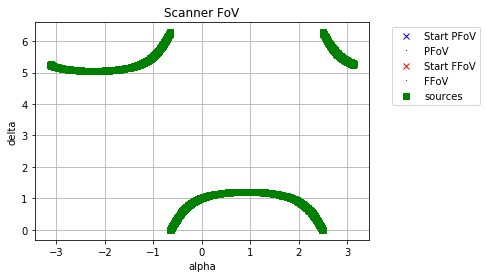

In [403]:
fig = plt.figure()
#plt.plot(aplhas[0], deltas[0], 's')
plt.plot(alphas_P[0], deltas_P[0], 'bx', label='Start PFoV')
plt.plot(alphas_P, deltas_P, 'b,', label='PFoV')
plt.plot(alphas_F[0], deltas_F[0], 'rx', label='Start FFoV')
plt.plot(alphas_F, deltas_F, 'r,', label='FFoV')

plt.plot(alphas[0]-np.pi, deltas[0], 'gs', label='sources')
for a,d in zip(alphas[1:], deltas[1:]):
    plt.plot(a-np.pi, d, 'gs')

plt.title("Scanner FoV")
plt.legend(loc=9, bbox_to_anchor=(1.2, 1))
plt.grid(True), plt.xlabel('alpha'), plt.ylabel('delta')
plt.show()

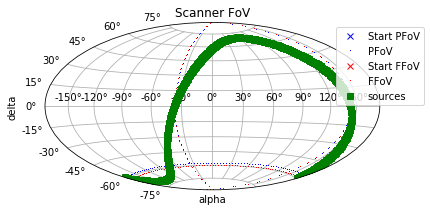

In [404]:
fig = plt.figure()
plt.subplot(111, projection="hammer")
#plt.plot(aplhas[0], deltas[0], 's')
plt.plot(alphas_P[0], deltas_P[0], 'bx', label='Start PFoV')
plt.plot(alphas_P, deltas_P, 'b,', label='PFoV')
plt.plot(alphas_F[0], deltas_F[0], 'rx', label='Start FFoV')
plt.plot(alphas_F, deltas_F, 'r,', label='FFoV')

plt.plot(alphas[0]-np.pi, deltas[0], 'gs', label='sources')
for a,d in zip(alphas[1:], deltas[1:]):
    plt.plot(a-np.pi, d, 'gs')

plt.title("Scanner FoV")
plt.legend(loc=9, bbox_to_anchor=(1, 1))
plt.grid(True), plt.xlabel('alpha'), plt.ylabel('delta')
plt.show()

In [405]:
# create soures from that: 
sources = []
for n in range(num_sources):
    sources.append(Source(str(n), np.degrees(alphas[n]), np.degrees(deltas[n]), 10, 10, 10, 10))
    # sources.append(Source(str(n), alphas[n], deltas[n], parallaxes[n], mu_alphas[n], mu_deltas[n], mu_radials[n]))
print('Sources created')

Sources created


# **Scan**

In [406]:
obs_times = []
calc_sources = []
real_sources = []
for s in sources:
    my_scanner.scan(gaia, s, ti=t_init, tf=t_end)
    my_scanner.compute_angles_eta_zeta(gaia, s)
    print('zetas:', my_scanner.zeta_scanned)
    print('etas:', my_scanner.eta_scanned)
    print('times:', my_scanner.obs_times)
    print('How many observation time?  {}'.format(len(my_scanner.obs_times)))
    if len(my_scanner.obs_times)>0:
        obs_times += my_scanner.obs_times
        print('Error: ', my_scanner.scanner_error())
        real_sources.append(s)
        calc_sources.append(Calc_source(obs_times=my_scanner.obs_times.copy(), source=s))
    print('------------------------------------------------------')
sources = real_sources
obs_times = list(np.sort(obs_times))

Starting scan with time from 0 to 0.5 days
Total measured time: 0.009162425994873047
zetas: [-0.003036259621374829, -0.007634525324343719]
etas: [2.220446049250313e-16, 1.1102230246251565e-16]
times: [0.07395775501185588, 0.4260308395899975]
How many observation time?  2
Error:  1.6653345369377348e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.014382123947143555
zetas: [-2.5522953254336632e-08, -0.01068830140630907, -0.031991542640748605]
etas: [0.0, 2.220446049250313e-16, 0.0]
times: [2.3238735018900833e-09, 0.14791847579346565, 0.49998069828084074]
How many observation time?  3
Error:  7.401486830834377e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.013795852661132812
zetas: [0.016722742349523256]
etas: [2.220446049250313e-16]
times: [0.35209967398105246]
How many observation time?  1
Error:  2.220446049250313e-16
----------------

times: [0.02006689229999137, 0.1679901339952843]
How many observation time?  2
Error:  3.3306690738754696e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.006594419479370117
zetas: [-2.485982932010078e-08, 0.011523762602581764]
etas: [0.0, -2.220446049250313e-16]
times: [0.020066887807123845, 0.3721655451468849]
How many observation time?  2
Error:  -1.1102230246251565e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.00883793830871582
zetas: [-0.004332870258498608, -0.015115332578085222]
etas: [-1.1102230246251565e-16, 1.1102230246251565e-16]
times: [0.09570108186881972, 0.44776477795889824]
How many observation time?  2
Error:  0.0
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.006531476974487305
zetas: [-2.548850556874718e-08, -0.011400925762354542]
etas: [2.220

Total measured time: 0.007413148880004883
zetas: [-0.005279894648149738, -0.020617924272978934]
etas: [1.1102230246251565e-16, 1.1102230246251565e-16]
times: [0.11409302236372872, 0.4661548553159476]
How many observation time?  2
Error:  1.1102230246251565e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.006850242614746094
zetas: [-2.482244659102704e-08, -0.011417613039731907]
etas: [-1.1102230246251565e-16, -1.1102230246251565e-16]
times: [0.0401337821581376, 0.18805572117438746]
How many observation time?  2
Error:  -1.1102230246251565e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.007337808609008789
zetas: [-2.4792533089013074e-08, 0.0056870716260493176]
etas: [-2.220446049250313e-16, 1.1102230246251565e-16]
times: [0.04013377805360837, 0.3922232345921127]
How many observation time?  2
Error:  -5.551115123125783e-17
---------------

Starting scan with time from 0 to 0.5 days
Total measured time: 0.013262033462524414
zetas: [-2.5510638304929167e-08, -0.010821387208210163]
etas: [1.1102230246251565e-16, -1.1102230246251565e-16]
times: [0.0602006717973558, 0.20812439182193718]
How many observation time?  2
Error:  0.0
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.013765096664428711
zetas: [-2.452463548907602e-08, -0.0004344925365826062]
etas: [2.220446049250313e-16, 3.3306690738754696e-16]
times: [0.060200668397913805, 0.41228399006795485]
How many observation time?  2
Error:  2.7755575615628914e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.0072214603424072266
zetas: [-0.006159909672725969, -0.02574394098539908]
etas: [-1.1102230246251565e-16, 4.440892098500626e-16]
times: [0.1358330422705797, 0.4879003692764796]
How many observation time?  2
Error:  1.6653345369377

Total measured time: 0.0071523189544677734
zetas: [-2.56729221145835e-08, -0.009618936946241163]
etas: [0.0, -1.1102230246251565e-16]
times: [0.08026756128351897, 0.22819164698201702]
How many observation time?  2
Error:  -5.551115123125783e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.00959920883178711
zetas: [-2.5203381048832793e-08, -0.006460006998865459]
etas: [-2.220446049250313e-16, 0.0]
times: [0.08026755873687663, 0.4323453981191599]
How many observation time?  2
Error:  -1.1102230246251565e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.006571531295776367
zetas: [0.004346673453704721, -0.006688743576534898]
etas: [-3.3306690738754696e-16, -2.220446049250313e-16]
times: [0.007977611412466539, 0.15589965485426135]
How many observation time?  2
Error:  -2.7755575615628914e-16
---------------------------------------------------

Total measured time: 0.007112026214599609
zetas: [-2.582711171317254e-08, -0.008050541657934104]
etas: [0.0, -3.3306690738754696e-16]
times: [0.09866220982780045, 0.24658535787453226]
How many observation time?  2
Error:  -1.6653345369377348e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.00705718994140625
zetas: [-2.4862101127842706e-08, -0.011567047421248177]
etas: [0.0, 0.0]
times: [0.09866220818789687, 0.45073422570571714]
How many observation time?  2
Error:  0.0
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.007147789001464844
zetas: [0.004554581996094068, -0.006901588590934485]
etas: [0.0, 3.3306690738754696e-16]
times: [0.02637333262192399, 0.1742945794675472]
How many observation time?  2
Error:  1.6653345369377348e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measure

Total measured time: 0.0072247982025146484
zetas: [0.004429047884276281, -0.006780436241911159]
etas: [-1.1102230246251565e-16, -1.1102230246251565e-16]
times: [0.0497869293888578, 0.19770691165870052]
How many observation time?  2
Error:  -1.1102230246251565e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.007928609848022461
zetas: [-2.5966844785507707e-08, -0.0053461539467911075]
etas: [-4.440892098500626e-16, -1.1102230246251565e-16]
times: [0.12374582122288288, 0.2716689490681346]
How many observation time?  2
Error:  -2.7755575615628914e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.00708770751953125
zetas: [-2.477776728238013e-08, -0.017395156465416114]
etas: [-6.661338147750939e-16, 1.1102230246251565e-16]
times: [0.1237458210921708, 0.47581897414717333]
How many observation time?  2
Error:  -2.7755575615628914e-16
------------

How many observation time?  2
Error:  -5.551115123125783e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.015048980712890625
zetas: [-2.5662034358608914e-08, -0.0022369635247622317]
etas: [-1.1102230246251565e-16, -2.220446049250313e-16]
times: [0.14882943246487626, 0.29675127735291756]
How many observation time?  2
Error:  -1.6653345369377348e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.012661933898925781
zetas: [0.010732768506467375, -2.487363781611407e-08]
etas: [0.0, -3.3306690738754696e-16]
times: [0.0009109339076134869, 0.1488294337476349]
How many observation time?  2
Error:  -1.6653345369377348e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.008694648742675781
zetas: [0.003763775878212861, -0.006121011825935088]
etas: [1.1102230246251565e-16, 2.2204

------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.00742650032043457
zetas: [0.0027821458891405305, -0.0051435080323067]
etas: [0.0, -1.1102230246251565e-16]
times: [0.09995412384083993, 0.24787454140018655]
How many observation time?  2
Error:  -5.551115123125783e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.007957935333251953
zetas: [-2.523724279557272e-08, 0.0009760905006651239]
etas: [0.0, 0.0]
times: [0.17391304363461793, 0.32183200661750283]
How many observation time?  2
Error:  0.0
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.006676435470581055
zetas: [0.011452731484290922, -2.4968985268269954e-08]
etas: [1.1102230246251565e-16, -2.220446049250313e-16]
times: [0.02599393085921991, 0.17391304623259005]
How many observation time?  2
Error:  -5.551115123125783e

zetas: [0.011306969388227811, -2.48834408633769e-08]
etas: [1.1102230246251565e-16, 1.1102230246251565e-16]
times: [0.0460636806312367, 0.19397993606046496]
How many observation time?  2
Error:  1.1102230246251565e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.00693202018737793
zetas: [0.0016113385417861827, -0.003975364093537534]
etas: [0.0, -3.3306690738754696e-16]
times: [0.12169243479445403, 0.26961389816650483]
How many observation time?  2
Error:  -1.6653345369377348e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.006957292556762695
zetas: [-2.5497412292629924e-08, 0.003599552424610104]
etas: [-1.1102230246251565e-16, -6.661338147750939e-16]
times: [0.19565217328883822, 0.3435703534491105]
How many observation time?  2
Error:  -3.885780586188048e-16
------------------------------------------------------
Starting scan with time 

Error:  0.0
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.007382392883300781
zetas: [0.010433505387934012, -2.5350453791705974e-08]
etas: [-1.1102230246251565e-16, 0.0]
times: [0.06780228646092994, 0.21571906644281785]
How many observation time?  2
Error:  -5.551115123125783e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.006841897964477539
zetas: [0.00028034989569514614, -0.0026455482691313233]
etas: [0.0, -1.1102230246251565e-16]
times: [0.14343058280458834, 0.2913523118615886]
How many observation time?  2
Error:  -5.551115123125783e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.007974863052368164
zetas: [-2.5408015746908322e-08, 0.005870916361974685]
etas: [0.0, 2.220446049250313e-16]
times: [0.21739130295795492, 0.3653078388675085]
How many observation ti

times: [0.1618251162681447, 0.3097467537049768]
How many observation time?  2
Error:  -1.6653345369377348e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.007434844970703125
zetas: [-2.5516337542885733e-08, 0.007392244695477998]
etas: [-1.1102230246251565e-16, 1.1102230246251565e-16]
times: [0.2357859512739331, 0.3837020738935497]
How many observation time?  2
Error:  0.0
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.007191658020019531
zetas: [0.009020010882209398, -2.5424471694623915e-08]
etas: [1.1102230246251565e-16, 1.1102230246251565e-16]
times: [0.08787067615380777, 0.23578595586070591]
How many observation time?  2
Error:  1.1102230246251565e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.006936788558959961
zetas: [-0.001008069340023, -0.00135760810713777

Total measured time: 0.00898885726928711
zetas: [-0.0022682501117016066, -9.62015120589358e-05]
etas: [1.1102230246251565e-16, 0.0]
times: [0.18356387281143918, 0.33148488145830013]
How many observation time?  2
Error:  5.551115123125783e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.007751941680908203
zetas: [-2.5550928428597072e-08, 0.008601960398425338]
etas: [2.220446049250313e-16, 0.0]
times: [0.25752508118392925, 0.405440337537298]
How many observation time?  2
Error:  1.1102230246251565e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.009748220443725586
zetas: [0.006938696485466163, -2.5623924676532194e-08]
etas: [1.1102230246251565e-16, 0.0]
times: [0.10960890037585715, 0.25752508587130457]
How many observation time?  2
Error:  5.551115123125783e-17
------------------------------------------------------
Starting scan with time

------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.008231163024902344
zetas: [0.005435589345391577, -2.5662204333753997e-08]
etas: [-1.1102230246251565e-16, 2.220446049250313e-16]
times: [0.12298591326518274, 0.27090301193903316]
How many observation time?  2
Error:  5.551115123125783e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.011146783828735352
zetas: [-0.0031489092589565447, 0.0007853592226219864]
etas: [0.0, 1.1102230246251565e-16]
times: [0.19861374870213933, 0.346535193765669]
How many observation time?  2
Error:  5.551115123125783e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.007186174392700195
zetas: [-2.4665315900840312e-08, 0.009020100190942095]
etas: [-2.220446049250313e-16, 2.220446049250313e-16]
times: [0.27257524815797035, 0.42049193164627247]
Ho

etas: [-1.1102230246251565e-16, -3.3306690738754696e-16]
times: [0.15308379843878142, 0.30100334541538293]
How many observation time?  2
Error:  -2.220446049250313e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.006632089614868164
zetas: [-0.004608040481599113, 0.0022491528249563735]
etas: [0.0, -4.440892098500626e-16]
times: [0.22871407576563701, 0.37663440683445903]
How many observation time?  2
Error:  -2.220446049250313e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.008556127548217773
zetas: [-2.512183655545286e-08, 0.008770770099169064]
etas: [0.0, -2.220446049250313e-16]
times: [0.3026755823659643, 0.4505927792731559]
How many observation time?  2
Error:  -1.1102230246251565e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.006736040115356445
zetas: [0.0

Error:  5.551115123125783e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.007262706756591797
zetas: [-0.0010905061023458484, -2.5816707504427987e-08]
etas: [-1.1102230246251565e-16, 0.0]
times: [0.17482232171940423, 0.3227424751102044]
How many observation time?  2
Error:  -5.551115123125783e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.006815195083618164
zetas: [-0.005319761376823146, 0.0029650227627362373]
etas: [-1.1102230246251565e-16, -6.661338147750939e-16]
times: [0.25045388962401366, 0.39837293295068193]
How many observation time?  2
Error:  -3.885780586188048e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.007621288299560547
zetas: [-2.4794596598098906e-08, 0.0077136066900883515]
etas: [0.0, -4.440892098500626e-16]
times: [0.3244147129026995, 0.472

zetas: [-2.478529836924537e-08, 0.006153127649320576]
etas: [3.3306690738754696e-16, 4.440892098500626e-16]
times: [0.34448160279166534, 0.4924028492581746]
How many observation time?  2
Error:  3.885780586188048e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.007539272308349609
zetas: [-0.0037031051060630684, -2.5519406830765146e-08]
etas: [2.220446049250313e-16, 2.220446049250313e-16]
times: [0.19655941613518013, 0.3444816047272263]
How many observation time?  2
Error:  2.220446049250313e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.006567716598510742
zetas: [-0.005681952817749105, 0.0033321791589732063]
etas: [-1.1102230246251565e-16, 4.440892098500626e-16]
times: [0.2721929572337721, 0.42011230470532973]
How many observation time?  2
Error:  1.6653345369377348e-16
------------------------------------------------------
Starting s

How many observation time?  2
Error:  -5.551115123125783e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.007858753204345703
zetas: [-0.013141172189715672, -2.472457399926853e-08]
etas: [0.0, 1.1102230246251565e-16]
times: [0.014147096167093443, 0.3662207337791402]
How many observation time?  2
Error:  5.551115123125783e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.008143186569213867
zetas: [-0.005955950304965875, -2.5924288160616985e-08]
etas: [0.0, -1.1102230246251565e-16]
times: [0.21829851657883464, 0.36622073441533004]
How many observation time?  2
Error:  -5.551115123125783e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.0073833465576171875
zetas: [-0.005668866964475981, 0.003323643578575819]
etas: [3.3306690738754696e-16, 2.220446049250313e-16]
times:

Total measured time: 0.0075685977935791016
zetas: [-0.005323926158927784, 0.002983687945510595]
etas: [-3.3306690738754696e-16, 2.220446049250313e-16]
times: [0.3140006368681309, 0.46191878136120257]
How many observation time?  2
Error:  -5.551115123125783e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.011601686477661133
zetas: [-0.0069616151305543095, -2.47611994796948e-08]
etas: [0.0, -2.220446049250313e-16]
times: [0.03588435574613759, 0.3879598648046505]
How many observation time?  2
Error:  -1.1102230246251565e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.007017374038696289
zetas: [-0.007682712085073656, -2.553742176059082e-08]
etas: [2.220446049250313e-16, -1.1102230246251565e-16]
times: [0.24003787039884136, 0.3879598642320789]
How many observation time?  2
Error:  5.551115123125783e-17
--------------------------------------

times: [0.2601061926223971, 0.40802675340378364]
How many observation time?  2
Error:  -1.6653345369377348e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.007567405700683594
zetas: [-0.004615110719445993, 0.0022814431329937373]
etas: [-1.1102230246251565e-16, 0.0]
times: [0.3357407151923263, 0.48366148447429264]
How many observation time?  2
Error:  -5.551115123125783e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.008838176727294922
zetas: [-0.0003569754845441877, -2.4274345949981676e-08]
etas: [1.1102230246251565e-16, 3.3306690738754696e-16]
times: [0.057615909759653625, 0.40969899596518433]
How many observation time?  2
Error:  2.220446049250313e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.006808280944824219
zetas: [-0.008756565370715891, -2.56171343027

------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.007201194763183594
zetas: [0.004213267212622668, -2.4457771807817608e-08]
etas: [1.1102230246251565e-16, -3.3306690738754696e-16]
times: [0.07265923740705062, 0.42474916374023325]
How many observation time?  2
Error:  -1.1102230246251565e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.007017612457275391
zetas: [-0.009073445884106341, -2.5238444972819345e-08]
etas: [-4.440892098500626e-16, -4.440892098500626e-16]
times: [0.27682807670010484, 0.424749161146015]
How many observation time?  2
Error:  -4.440892098500626e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.007535219192504883
zetas: [-0.020493829577408487, -0.0038635876593266527]
etas: [1.1102230246251565e-16, 5.551115123125783e-16]
times: [0.000401077774492979

etas: [1.1102230246251565e-16, 0.0]
times: [0.09940930035445711, 0.45150501755975253]
How many observation time?  2
Error:  5.551115123125783e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.007384538650512695
zetas: [-0.008740897709603884, -2.476807864359998e-08]
etas: [3.3306690738754696e-16, -1.1102230246251565e-16]
times: [0.30358642892272597, 0.4515050137839779]
How many observation time?  2
Error:  1.1102230246251565e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.008651971817016602
zetas: [-0.01190180614827288, -0.002379171733396717]
etas: [1.1102230246251565e-16, -2.220446049250313e-16]
times: [0.02714974451838503, 0.3792188967192297]
How many observation time?  2
Error:  -5.551115123125783e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.00702929496765

Error:  2.220446049250313e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.007829904556274414
zetas: [0.01687087730394924, -2.4730519597448986e-08]
etas: [0.0, 1.1102230246251565e-16]
times: [0.12114308545357112, 0.4732441486854375]
How many observation time?  2
Error:  5.551115123125783e-17
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.008288860321044922
zetas: [-0.007654405286267159, -2.496483028635588e-08]
etas: [2.220446049250313e-16, 0.0]
times: [0.3253248200897641, 0.4732441443560444]
How many observation time?  2
Error:  1.1102230246251565e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.006541013717651367
zetas: [-0.004057096461554433, -0.0010232964604678285]
etas: [0.0, 2.220446049250313e-16]
times: [0.04887854758710422, 0.40095543796646643]
How many obs

zetas: [0.00335778286252414, 0.00026503950569162357]
etas: [-1.1102230246251565e-16, -3.3306690738754696e-16]
times: [0.0689333900802045, 0.4210224296196392]
How many observation time?  2
Error:  -2.220446049250313e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.007220268249511719
zetas: [0.020651435791424946, -2.493072369033622e-08]
etas: [3.3306690738754696e-16, 1.1102230246251565e-16]
times: [0.1428811953208395, 0.4949832797012577]
How many observation time?  2
Error:  2.220446049250313e-16
------------------------------------------------------
Starting scan with time from 0 to 0.5 days
Total measured time: 0.007037162780761719
zetas: [-0.0059158871554340865, -2.5271715303754053e-08]
etas: [0.0, 5.551115123125783e-16]
times: [0.34706402185520374, 0.49498327509482476]
How many observation time?  2
Error:  2.7755575615628914e-16
------------------------------------------------------
Starting scan with time fr

In [407]:
print('t_end: ', t_end)
if list(np.array(obs_times)[np.where(np.array(obs_times)>t_end)]):
    raise ValueError('observed time greater than end time')

t_end:  0.5


# **2- Combine with solver:**

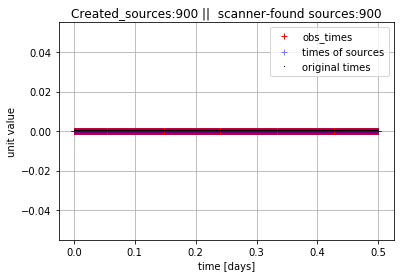

(None, <matplotlib.legend.Legend at 0x7fedd16217b8>, None)

In [408]:
plt.figure()

plt.title('Created_sources:'+str(num_sources)+' ||  scanner-found sources:'+str(len(calc_sources)))

plt.plot(obs_times,np.zeros(len(obs_times)), 'r+', label='obs_times')

plt.plot(times_for_source, np.zeros(len(times_for_source)), 'b+', label='times of sources', alpha=0.5)

sampled_times = np.linspace(t_init, t_end, num=500)
plt.plot(sampled_times, np.zeros(len(sampled_times)), 'k,', label='original times')

plt.xlabel('time [days]'), plt.ylabel('unit value') # , plt.ylim((-1e-6, 1e-6))

plt.grid(), plt.legend(), plt.show()

#bins: 12


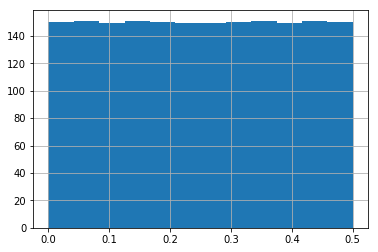

In [409]:
bins = int((t_end-t_init)/my_dt)
print('#bins:', bins)
plt.hist(obs_times, bins=bins, align='mid');
plt.grid();


In [410]:
def noise_calc_sources(s):
    noise = 0.02 / 10
    s.s_params[0] += noise
    s.s_params[1] += noise
    s.s_params[2] += -s.s_params[2]/100
    s.s_params[3] += s.s_params[3]*0.01
    s.s_params[4] += s.s_params[4]*0.01

In [411]:
print('Updating only sources:')
Solver = Agis(gaia, calc_sources, sources, updating='scanned source', double_telescope=double_telescope)

Updating only sources:


In [412]:
Solver.error_function()

0.0

In [413]:
# Solver.reset_iterations()
#Solver.iterate(1)

# *Update Attitude*

In [414]:
if len(sources) != len(calc_sources):
    raise ValueError('there must be the same number of real and calc sources')

In [429]:
print('Updating attitude')
spline_degree = 3
Solver = Agis(sat=gaia, calc_sources=calc_sources, real_sources=sources, updating='attitude',
              double_telescope=double_telescope,
              attitude_splines=[gaia.s_w, gaia.s_x, gaia.s_y, gaia.s_z], 
              spline_degree=spline_degree,
              attitude_regularisation_factor=5e-5)

Updating attitude


In [430]:
# Ignore this cell if you don't want to modify the initial attitude
# Can be used to check that when recreating the splines in the solver we (almost) do not create additional errors
my_times = np.array(obs_times)
# Solver.actualise_splines()
print('Error before Noise: ', Solver.error_function())
# print('Errors after noise of attitude (not representatif):', error_between_func_attitudes(my_times, gaia.func_attitude, Solver.get_attitude))
c_noise = Solver.att_coeffs * np.random.rand(Solver.att_coeffs.shape[0], Solver.att_coeffs.shape[1]) * 1e-6
print('c_noise shape: ', c_noise.shape)
last_coef = 4
#Solver.att_coeffs[:last_coef] = Solver.att_coeffs[:last_coef] + c_noise[:last_coef]
Solver.actualise_splines()
#Solver.set_splines_basis()
print('Error after Noise: ', Solver.error_function())
# print('Errors after noise of attitude (not representatif):', error_between_func_attitudes(my_times, gaia.func_attitude, Solver.get_attitude))

Error before Noise:  3.5256654887864165e-29
c_noise shape:  (4, 13)
Error after Noise:  3.5256654887864165e-29


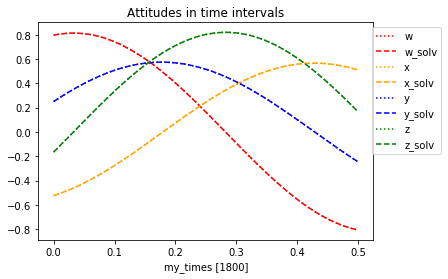

In [431]:
compare_attitudes(gaia, Solver, obs_times)

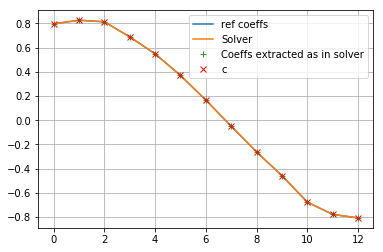

(None, <matplotlib.legend.Legend at 0x7fedd022ee10>, None)

In [432]:
to_fit = gaia.s_w
c, t, s = extract_coeffs_knots_from_splines([gaia.s_w, gaia.s_x, gaia.s_y, gaia.s_z], k=3)
a_ref = to_fit.get_coeffs()
plt.plot(a_ref, label='ref coeffs')
plt.plot(Solver.att_coeffs[0], label='Solver')
plt.plot(c[0], '+', label='Coeffs extracted as in solver')
plt.plot(Solver.c[0], 'rx', label='c')
plt.grid(), plt.legend(), plt.show()

**Plot matrices:**

In [433]:
if (Solver.att_knots.shape[0] - Solver.att_coeffs.shape[1]) != 4:
    raise ValueError('there should be 4 coeffs less than the number of knots')

In [434]:
N_aa = Solver.compute_attitude_LHS()

N_aa_dim: 13


In [435]:
N_aa_w = N_aa[0::4, 0::4]
N_aa_x = N_aa[1::4, 1::4]
N_aa_y = N_aa[2::4, 2::4]
N_aa_z = N_aa[3::4, 3::4]
N_aa_list = [N_aa_w, N_aa_x, N_aa_y, N_aa_z]
print('N_aa_w.shape', N_aa_w.shape)
print('N_aa_z.shape', N_aa_z.shape)

N_aa_w.shape (13, 13)
N_aa_z.shape (13, 13)


Text(0.5, 0.98, 'Matrix visualization')

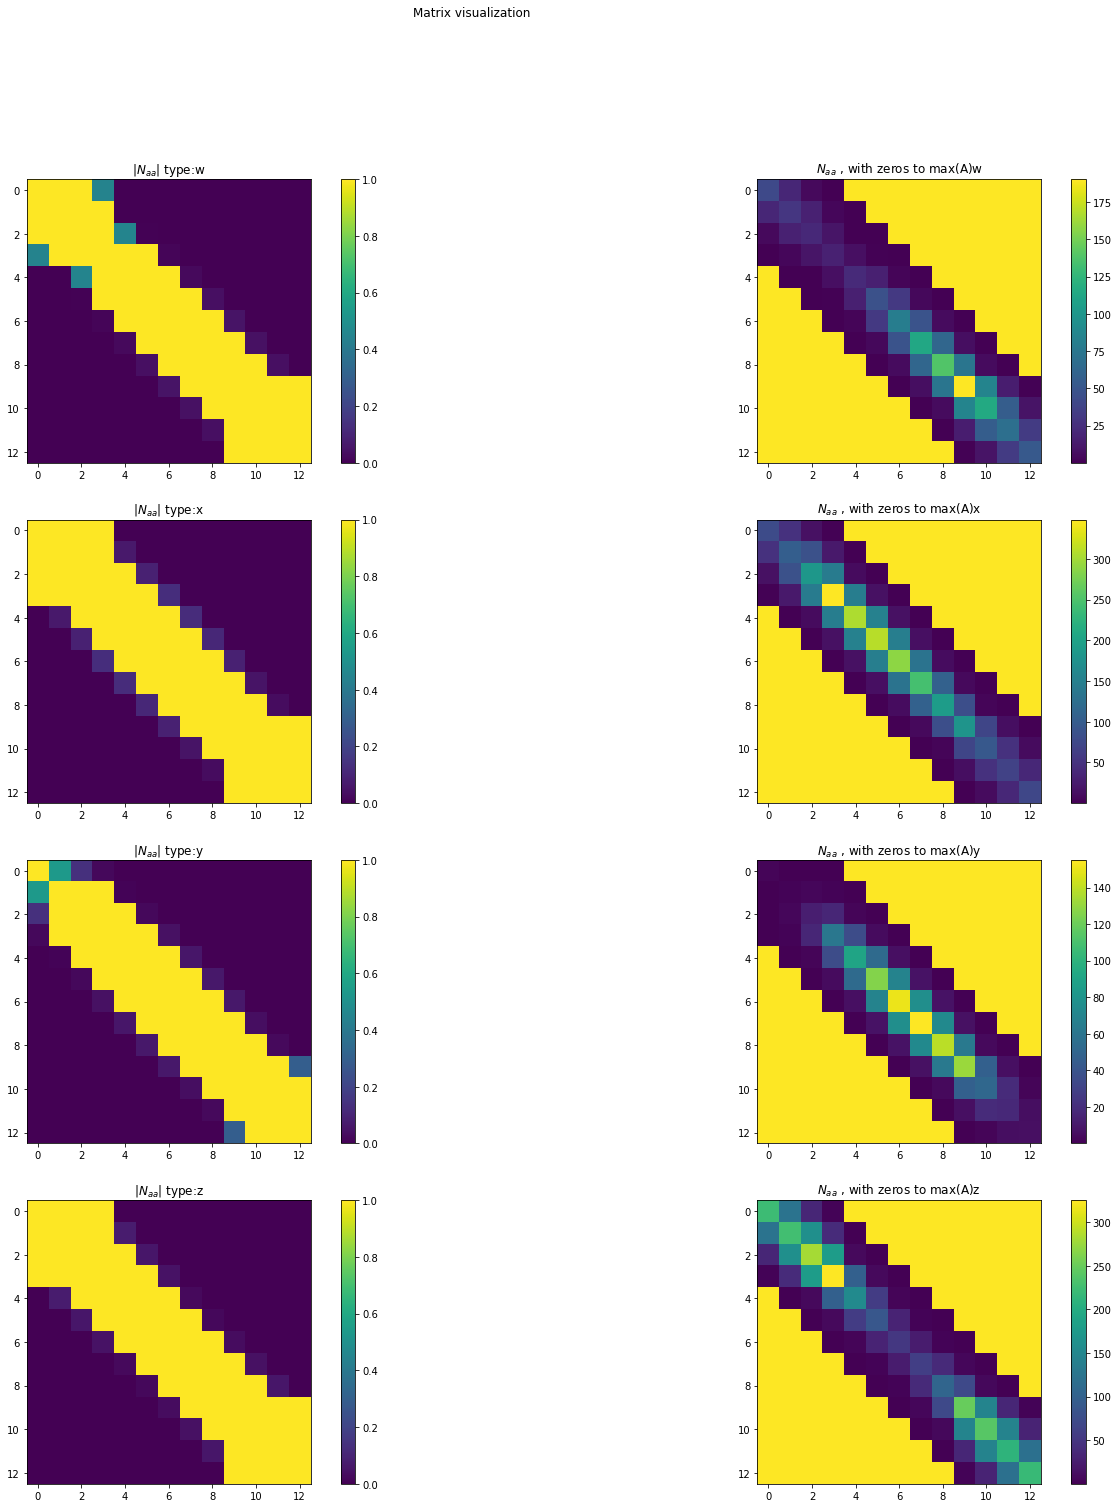

In [436]:
fig, axs = plt.subplots(4, 2, figsize=(24, 24))

type_list = ['w', 'x', 'y', 'z']
for i in range(4):
    A = N_aa_list[i].copy()
    plot1 = axs[i, 0].imshow(np.abs(A), vmin=None, vmax=1)
    axs[i, 0].set_title("$|N_{aa}|$ type:"+type_list[i])
    
    threshold = 0
    A[np.where(A==threshold)] = A.max()
    plot2 = axs[i, 1].imshow(A, vmin=None, vmax=None)
    axs[i, 1].set_title("$N_{aa}$ , with zeros to max(A)"+type_list[i])

    fig.colorbar(plot1, ax=axs[i, 0])
    fig.colorbar(plot2, ax=axs[i, 1])
    
fig.suptitle('Matrix visualization')
# plt.show()

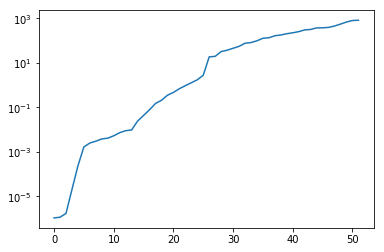

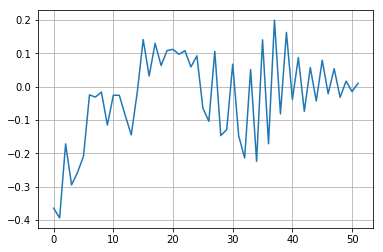

In [437]:
eig_vals, eig_vecs = np.linalg.eigh(N_aa)
plt.plot(eig_vals, label=type_list[i])
    
plt.yscale('log')
#plt.xlim(0,5)
plt.show()


plt.plot(eig_vecs[0])
#plt.xlim(100,110)
plt.grid()

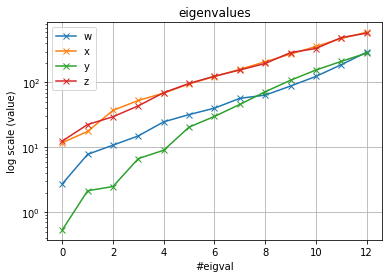

In [438]:
for i, Naa in enumerate(N_aa_list):
    eig_vals, eig_vecs = np.linalg.eigh(Naa)
    plt.plot(eig_vals, label=type_list[i],marker='x')
    if not helpers.check_symmetry(Naa):
        raise ValueError('Matrix not symmetric')
    # print('Condition number: ', np.linalg.cond(Naa))
    # print('Condition number (eig_max/eig_min): ', np.abs(eig_vals.max())/np.abs(eig_vals.min()))
    # print('Rank: ', np.linalg.matrix_rank(Naa, hermitian=True))
    # print('det(N_aa):', np.linalg.det(Naa),'\n')
plt.yscale('log'), plt.legend(), plt.grid()
plt.title('eigenvalues'), plt.ylabel('log scale (value)'), plt.xlabel('#eigval')
# plt.xlim((0,5))

plt.show()

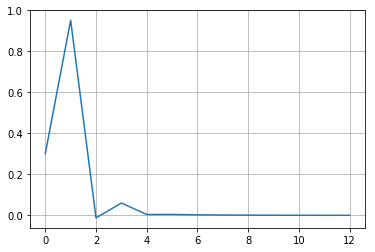

In [439]:
eig_vals, eig_vecs = np.linalg.eigh(N_aa_list[2])
plt.plot(eig_vecs[0])
plt.grid()

# **See iterations**

***** Iteration: 1 *****
N_aa_dim: 13
attitude error: 0.07341746921090198
Error after iteration: 3.151313515996587e-07


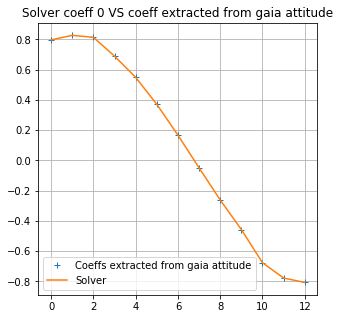

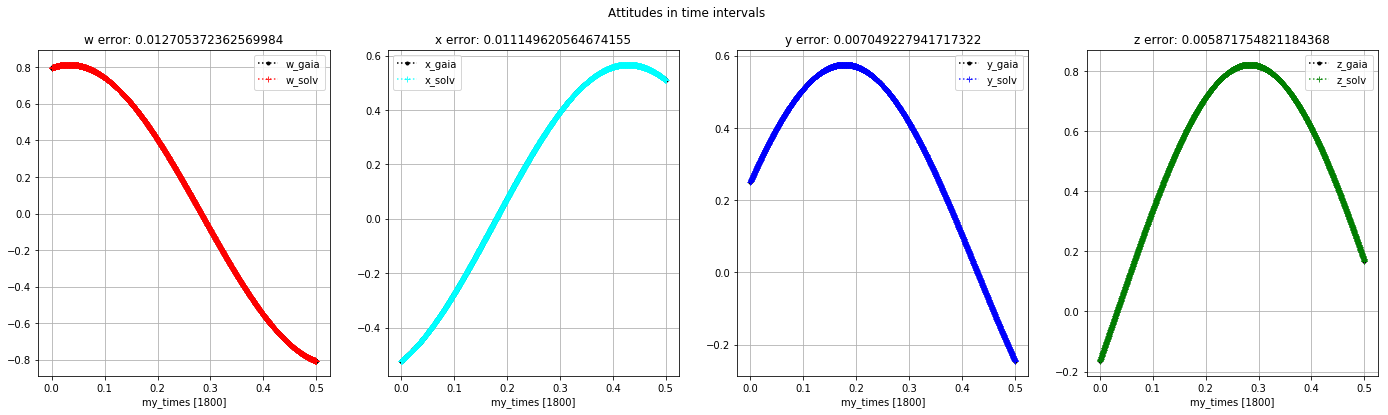

MAGNITUDE: 1.0000417946271751


In [440]:
Solver.verbose=False
# Solver.reset_iterations()
Solver.iterate(1)

plt.figure(figsize=(5,5))
c, t, s = extract_coeffs_knots_from_splines([gaia.s_w, gaia.s_x, gaia.s_y, gaia.s_z], k=3)
plt.plot(c[0], '+', label='Coeffs extracted from gaia attitude')
plt.plot(Solver.att_coeffs[0], label='Solver')
plt.title('Solver coeff 0 VS coeff extracted from gaia attitude')
plt.grid(), plt.legend(), plt.show()
fig2 = multi_compare_attitudes(gaia, Solver, obs_times)
print('MAGNITUDE:', Solver.get_attitude(0.005, unit=False).magnitude)
fig2.savefig('lala.png')

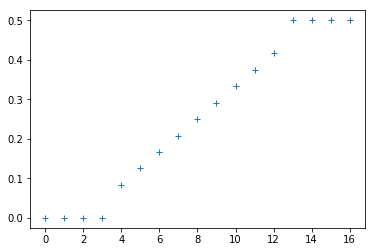

In [441]:
plt.plot(Solver.att_knots, '+')
plt.show()

In [442]:
Solver.iterate(100)

***** Iteration: 2 *****
N_aa_dim: 13
attitude error: 0.08094700605073665
Error after iteration: 2.274490896367135e-07
***** Iteration: 3 *****
N_aa_dim: 13
attitude error: 0.09729027954745706
Error after iteration: 3.2655868918931207e-07
***** Iteration: 4 *****
N_aa_dim: 13
attitude error: 0.12685238201131732
Error after iteration: 6.385145059773529e-07
***** Iteration: 5 *****
N_aa_dim: 13
attitude error: 0.18193069296430628
Error after iteration: 1.8167249517679337e-06
***** Iteration: 6 *****
N_aa_dim: 13


KeyboardInterrupt: 

In [ ]:
fig2 = multi_compare_attitudes(gaia, Solver, obs_times)


In [61]:
B = A.copy()
A = Solver.compute_attitude_LHS()
print((B-A).sum())

N_aa_dim: 25
-2793.8023511538568


In [62]:
hi = h
h = Solver.compute_attitude_RHS()
print((hi-h).sum())

-9.217095069543289e-12
